## Pre-Processing

In [12]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Karan\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['pylab', 'colors', 'clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [ ]:
#%#run json_to_csv_converter.py "Data/yelp_academic_dataset_business.json"
#%run json_to_csv_converter.py "Data/yelp_academic_dataset_review.json"

In [13]:
import time
import datetime

import cPickle as pickle
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import pylab
import re
import scipy as sp
import seaborn

from gensim import corpora, models
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.lda import LDA
from sklearn.qda import QDA
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, auc

plt.rc('figure', figsize=(10,6))
seaborn.set()
colors = seaborn.color_palette()

In [14]:
business_data = pd.read_csv("Data/yelp_academic_dataset_business.csv", dtype=unicode)
review_data = pd.read_csv("Data/yelp_academic_dataset_review.csv")

In [4]:
len(review_data)

2685066

In [5]:
len(business_data)

85901

In [15]:
resto_business_data = business_data[business_data['categories'].str.contains('Restaurants')]

In [31]:
len(resto_business_data)

26729

In [19]:
resto_review_data = review_data.merge(resto_business_data,
                                         left_on='business_id',
                                         right_on='business_id',
                                         suffixes=('_review', '_business'))

In [87]:
len(resto_review_data)

1630712

In [88]:
list(resto_review_data)

['user_id',
 'review_id',
 'text',
 'votes.cool',
 'business_id',
 'votes.funny',
 'stars_review',
 'date',
 'type_review',
 'votes.useful',
 'attributes.Ambience.divey',
 'attributes.Dietary Restrictions.vegan',
 'attributes.Happy Hour',
 'hours.Thursday.open',
 'attributes.Order at Counter',
 'attributes.Hair Types Specialized In.africanamerican',
 'attributes.Hair Types Specialized In.kids',
 'attributes.BYOB',
 'hours.Friday.open',
 'attributes.Good For.latenight',
 'attributes.Outdoor Seating',
 'attributes.Alcohol',
 'attributes.Ambience.classy',
 'attributes.By Appointment Only',
 'attributes.Parking.lot',
 'attributes.Ambience.touristy',
 'attributes.Corkage',
 'hours.Tuesday.open',
 'attributes.Good For.brunch',
 'categories',
 'attributes.Waiter Service',
 'hours.Monday.open',
 'name',
 'attributes.Parking.street',
 'attributes.Ambience.hipster',
 'attributes.BYOB/Corkage',
 'attributes.Hair Types Specialized In.straightperms',
 'attributes.Music.live',
 'attributes.Dietary R

In [20]:
resto_review_data = resto_review_data.ix[:,['text','stars_review']]

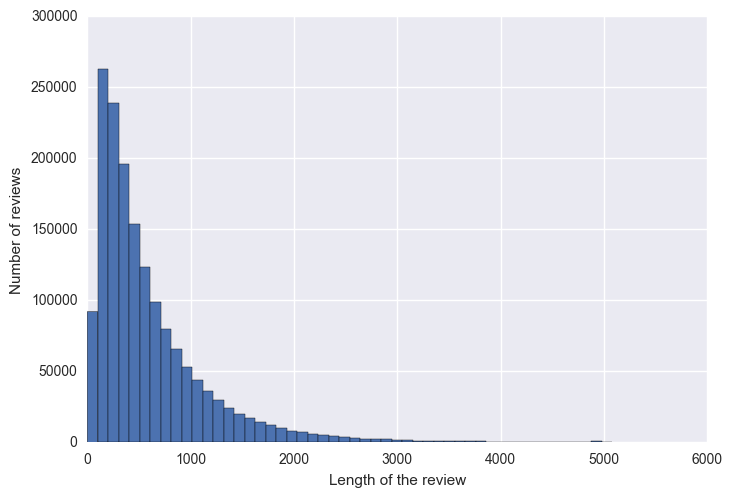

In [79]:
resto_review_data.text.dropna().str.len().hist(bins=50)
xlabel('Length of the review')
ylabel('Number of reviews')

In [21]:
minReviewLen = 50
resto_review_reduced = resto_review_data[resto_review_data.text.str.len() > minReviewLen]

In [91]:
len(resto_review_reduced)

1610512

In [22]:
maxReviewLen = 500
resto_review_reduced = resto_review_reduced[resto_review_reduced.text.str.len() < maxReviewLen]

In [93]:
len(resto_review_reduced)

910340

In [23]:
resto_review = resto_review_reduced

In [ ]:
pickle.dump(resto_review, open("resto_review.p", "wb"))

In [24]:
resto_review.stars_review = resto_review.stars_review.astype(float)

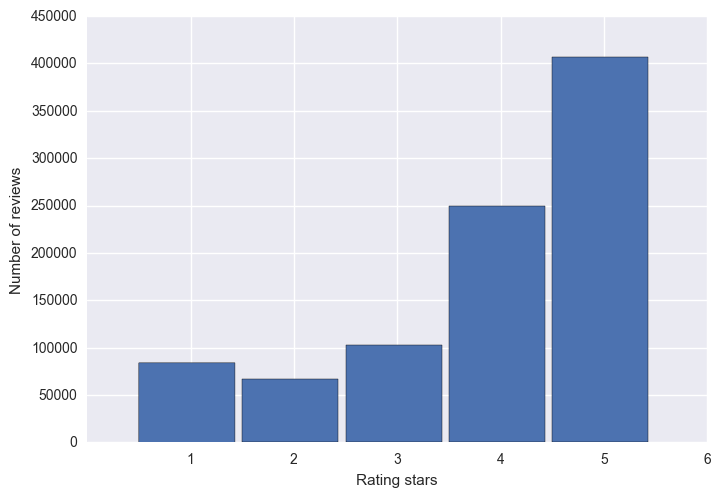

In [96]:
bins = [1, 2, 3 ,4, 5, 6]
resto_review.stars_review.hist(bins=bins, align='left', width=0.93)
xticks(bins)
xlabel('Rating stars')
ylabel('Number of reviews')
plt.show()

## Baseline Model

In [98]:
resto_review['predicted_rating'] = round(sum(resto_review.stars_review)/len(resto_review.index))
print "Baseline Rating:", round(sum(resto_review.stars_review)/len(resto_review.index))

Baseline Rating: 4.0


In [100]:
len(resto_review)

910340

In [108]:
precision = metrics.precision_score(resto_review.stars_review, resto_review.predicted_rating)
recall = metrics.recall_score(resto_review.stars_review, resto_review.predicted_rating)
f1 = metrics.f1_score(resto_review.stars_review, resto_review.predicted_rating)
accuracy = accuracy_score(resto_review.stars_review, resto_review.predicted_rating)

baselineResult = {}

data = {'precision':precision,
        'recall':recall,
        'f1_score':f1,
        'accuracy':accuracy}

baselineResult['Baseline'] = data
pd.DataFrame(baselineResult).T

C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weig

,accuracy,f1_score,precision,recall
Baseline,0.273578,0.117535,0.074845,0.273578


## Model 1 - Rating prediction from Topics extracted from reviews using LDA

In [110]:
stoplist = set(stopwords.words("english"))

In [4]:
numTopics = 15

In [27]:
starsGroup = resto_review.groupby('stars_review')

all_1stars_text = starsGroup.get_group(1.0)['text']
all_2stars_text = starsGroup.get_group(2.0)['text']
all_3stars_text = starsGroup.get_group(3.0)['text']
all_4stars_text = starsGroup.get_group(4.0)['text']
all_5stars_text = starsGroup.get_group(5.0)['text']

all_1stars_labels = [1.0]*len(all_1stars_text)
all_2stars_labels = [2.0]*len(all_2stars_text)
all_3stars_labels = [3.0]*len(all_3stars_text)
all_4stars_labels = [4.0]*len(all_4stars_text)
all_5stars_labels = [5.0]*len(all_5stars_text)

In [120]:
from sklearn.cross_validation import train_test_split

all_1stars_text_train, all_1stars_text_test, all_1stars_labels_train, all_1stars_labels_test = train_test_split(all_1stars_text, all_1stars_labels, test_size=0.20)
all_2stars_text_train, all_2stars_text_test, all_2stars_labels_train, all_2stars_labels_test = train_test_split(all_2stars_text, all_2stars_labels, test_size=0.20)
all_3stars_text_train, all_3stars_text_test, all_3stars_labels_train, all_3stars_labels_test = train_test_split(all_3stars_text, all_3stars_labels, test_size=0.20)
all_4stars_text_train, all_4stars_text_test, all_4stars_labels_train, all_4stars_labels_test = train_test_split(all_4stars_text, all_4stars_labels, test_size=0.20)
all_5stars_text_train, all_5stars_text_test, all_5stars_labels_train, all_5stars_labels_test = train_test_split(all_5stars_text, all_5stars_labels, test_size=0.20)

In [127]:
def process_reviews(dirty_data_set):
    clean_data_set = []
    for review in dirty_data_set:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        # To lowercase
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            clean_data_set.append(' '.join(texts))
        except:
            pass
    return clean_data_set

In [128]:
corpus_5stars = process_reviews(all_5stars_text_train)
corpus_4stars = process_reviews(all_4stars_text_train)
corpus_3stars = process_reviews(all_3stars_text_train)
corpus_2stars = process_reviews(all_2stars_text_train)
corpus_1stars = process_reviews(all_1stars_text_train)

print "Number of 5-star reviews after processing: ", len(corpus_5stars)
print "Number of 4-star reviews after processing: ", len(corpus_4stars)
print "Number of 3-star reviews after processing: ", len(corpus_3stars)
print "Number of 2-star reviews after processing: ", len(corpus_2stars)
print "Number of 1-star reviews after processing: ", len(corpus_1stars)

Number of 5-star reviews after processing:  325603
Number of 4-star reviews after processing:  199239
Number of 3-star reviews after processing:  82408
Number of 2-star reviews after processing:  53890
Number of 1-star reviews after processing:  67131


In [129]:
corpus_5stars

['best fish burrito ever good beer selection definitely looking forward coming back trying items',
 'discovered place first moved become addicted vegetarian grilled veggie wrap yummy friends told subs delicious well especially get mike way jersey mike favorite though staff always super friendly packer fans always come wrap watch packer game feel home',
 'worth wait like everyone else think place fantastic well remember french name want eat everything looks good bring things breakfast great stuff lady says control good also bring coffee beer pretty ideal noon',
 'place pretty hard beat bacon cheese burger cheese fries good happy hometown getting shake shack',
 'love place pittsburgh different fun people working always seem great time good vibes great food ps get mexican corn cob make ressie show always packed',
 'bruschetta amazing finest ingredients lovely setting kindest service gem organic remarkable first visit',
 'place amazing best pad thai ever also fairly inexpensive especially 

In [130]:
all_5_4_train = np.append(corpus_5stars, corpus_4stars)
all_5_4_3_train = np.append(all_5_4_train, corpus_3stars)
all_5_4_3_2_train = np.append(all_5_4_3_train, corpus_2stars)
all_text_train = np.append(all_5_4_3_2_train, corpus_1stars)

In [132]:
len(all_text_train)

728271

In [135]:
len(resto_review)*.8

728272.0

In [136]:
all_text_train

array([ 'best fish burrito ever good beer selection definitely looking forward coming back trying items',
       'discovered place first moved become addicted vegetarian grilled veggie wrap yummy friends told subs delicious well especially get mike way jersey mike favorite though staff always super friendly packer fans always come wrap watch packer game feel home',
       'worth wait like everyone else think place fantastic well remember french name want eat everything looks good bring things breakfast great stuff lady says control good also bring coffee beer pretty ideal noon',
       ...,
       'terrible service server rude took minutes get drink order forget food really wanted try worth wait terrible servicio mesera de mal humor grosera se tardan en atenderte para las bebidas ya ni hablar de la comida vale la pena',
       'one servers rude looks like guy blond hair ordering kept interrupting saying would order finishing food one bussed boys tried take vape juice luckily caught bot

In [149]:
def perform_lda(allReviewsTrain, numTopics):
    corpus = []
    for review in allReviewsTrain:
        # Remove punctuations
        review = re.sub(r'[^a-zA-Z]', ' ', review)
        # To lowercase
        review = review.lower()
        # Remove stop words
        texts = [word for word in review.lower().split() if word not in stoplist]
        try:
            corpus.append(texts)
        except:
            pass

    # Build dictionary
    dictionary = corpora.Dictionary(corpus)
    dictionary.save('restaurant_reviews.dict')
        
    # Build vectorized corpus
    corpus_2 = [dictionary.doc2bow(text) for text in corpus]
    #corpora.MmCorpus.serialize('LDA/restaurant_reviews.mm', corpus_2)
    
    lda = models.LdaModel(corpus_2, num_topics=numTopics, id2word=dictionary)
    return lda

In [150]:
%time lda = perform_lda(all_text_train, numTopics)

Wall time: 41min 44s


In [151]:
pickle.dump(lda, open("lda.p", "wb"))

In [153]:
# Generates a matrix of topic probabilities for each document in matrix
# Returns topic_dist for the input corpus, and all_dist, a running sum of all the corpuses
def generate_topic_dist_matrix(lda, numTopics, corpus, all_dist, star):
    topic_dist = [0] * numTopics
    dictionary = corpora.Dictionary.load("restaurant_reviews.dict")
    for doc in corpus:
        vec = dictionary.doc2bow(doc.lower().split())
        output = lda[vec]
        highest_prob = 0
        highest_topic = 0
        temp = [0] * numTopics    # List to keep track of topic distribution for each document
        for topic in output:
            this_topic, this_prob = topic
            temp[this_topic] = this_prob
            if this_prob > highest_prob:
                highest_prob = this_prob 
                highest_topic = this_topic
        temp.append(star)
        all_dist.append(temp)
        topic_dist[highest_topic] += 1
    return topic_dist, all_dist

In [154]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []


topic_dist_5stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_5stars, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_4stars, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_3stars, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_2stars, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_1stars, topic_dist_list, 1)

cols = []
for i in xrange(1, numTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

topic_dist_train_1_2_3_4_5_df = pd.DataFrame(topic_dist_list, columns=cols)

In [156]:
pickle.dump(topic_dist_train_1_2_3_4_5_df, open("topic_dist_train_1_2_3_4_5_df.p", "wb"))

In [160]:
topic_dist_train_1_2_3_4_5_df.head(2)

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Star
0,0.519299,0.000000,0.0,0.186159,0.0,0.000000,0.114828,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.130824,0.000000,5
1,0.000000,0.301603,0.0,0.000000,0.0,0.311031,0.000000,0.0,0.0,0.0,0.110127,0.131572,0.030217,0.040812,0.060963,5


In [161]:
# Process the test reviews
corpus_5stars_test = process_reviews(all_5stars_text_test)
corpus_4stars_test = process_reviews(all_4stars_text_test)
corpus_3stars_test = process_reviews(all_3stars_text_test)
corpus_2stars_test = process_reviews(all_2stars_text_test)
corpus_1stars_test = process_reviews(all_1stars_text_test)

print "Number of 5-star reviews after processing: ", len(corpus_5stars_test)
print "Number of 4-star reviews after processing: ", len(corpus_4stars_test)
print "Number of 3-star reviews after processing: ", len(corpus_3stars_test)
print "Number of 2-star reviews after processing: ", len(corpus_2stars_test)
print "Number of 1-star reviews after processing: ", len(corpus_1stars_test)

Number of 5-star reviews after processing:  81401
Number of 4-star reviews after processing:  49810
Number of 3-star reviews after processing:  20602
Number of 2-star reviews after processing:  13473
Number of 1-star reviews after processing:  16783


In [162]:
all_5_4_test = np.append(corpus_5stars_test, corpus_4stars_test)
all_5_4_3_test = np.append(all_5_4_test, corpus_3stars_test)
all_5_4_3_2_test = np.append(all_5_4_3_test, corpus_2stars_test)
all_text_test = np.append(all_5_4_3_2_test, corpus_1stars_test)

In [163]:
pickle.dump(all_text_test, open("all_text_test.p", "wb"))
pickle.dump(all_text_train, open("all_text_train.p", "wb"))

In [164]:
pickle.dump(all_1stars_text_train, open("all_1stars_text_train.p", "wb"))
pickle.dump(all_2stars_text_train, open("all_2stars_text_train.p", "wb"))
pickle.dump(all_3stars_text_train, open("all_3stars_text_train.p", "wb"))
pickle.dump(all_4stars_text_train, open("all_4stars_text_train.p", "wb"))
pickle.dump(all_5stars_text_train, open("all_5stars_text_train.p", "wb"))

In [165]:
pickle.dump(all_1stars_text_test, open("all_1stars_text_test.p", "wb"))
pickle.dump(all_2stars_text_test, open("all_2stars_text_test.p", "wb"))
pickle.dump(all_3stars_text_test, open("all_3stars_text_test.p", "wb"))
pickle.dump(all_4stars_text_test, open("all_4stars_text_test.p", "wb"))
pickle.dump(all_5stars_text_test, open("all_5stars_text_test.p", "wb"))

In [166]:
pickle.dump(corpus_1stars, open("corpus_1stars.p", "wb"))
pickle.dump(corpus_2stars, open("corpus_2stars.p", "wb"))
pickle.dump(corpus_3stars, open("corpus_3stars.p", "wb"))
pickle.dump(corpus_4stars, open("corpus_4stars.p", "wb"))
pickle.dump(corpus_5stars, open("corpus_5stars.p", "wb"))

In [167]:
pickle.dump(corpus_1stars_test, open("corpus_1stars_test.p", "wb"))
pickle.dump(corpus_2stars_test, open("corpus_2stars_test.p", "wb"))
pickle.dump(corpus_3stars_test, open("corpus_3stars_test.p", "wb"))
pickle.dump(corpus_4stars_test, open("corpus_4stars_test.p", "wb"))
pickle.dump(corpus_5stars_test, open("corpus_5stars_test.p", "wb"))

In [168]:
topic_dist_list = []

# Keep a separate list to count topics
topic_dist_5stars = []
topic_dist_4stars = []
topic_dist_3stars = []
topic_dist_2stars = []
topic_dist_1stars = []


topic_dist_5stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_5stars_test, topic_dist_list, 5)
topic_dist_4stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_4stars_test, topic_dist_list, 4)
topic_dist_3stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_3stars_test, topic_dist_list, 3)
topic_dist_2stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_2stars_test, topic_dist_list, 2)
topic_dist_1stars, topic_dist_list = generate_topic_dist_matrix(lda, numTopics, corpus_1stars_test, topic_dist_list, 1)

cols = []
for i in xrange(1, numTopics+1):
    cols.append("Topic"+ str(i))
cols.append("Star")

topic_dist_test_1_2_3_4_5_df = pd.DataFrame(topic_dist_list, columns=cols)

pickle.dump(topic_dist_test_1_2_3_4_5_df, open("topic_dist_test_1_2_3_4_5_df.p", "wb"))

In [169]:
topic_dist_test_1_2_3_4_5_df.head(2)

,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Star
0,0.103989,0.133595,0.048959,0.000000,0.0,0.163216,0.0,0.334831,0.0,0.0,0.118497,0.000000,0.0,0.082877,0.0,5
1,0.080547,0.000000,0.000000,0.206186,0.0,0.515759,0.0,0.091926,0.0,0.0,0.000000,0.084077,0.0,0.000000,0.0,5


In [6]:
features = list(topic_dist_train_1_2_3_4_5_df.columns[:numTopics])

In [9]:
x_train = topic_dist_train_1_2_3_4_5_df[features]
y_train = topic_dist_train_1_2_3_4_5_df['Star']

x_test = topic_dist_test_1_2_3_4_5_df[features]
y_test = topic_dist_test_1_2_3_4_5_df['Star'] 

In [28]:
clfs = [KNeighborsClassifier(), MultinomialNB(), LogisticRegression(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
clf_names = ['Nearest Neighbors', 'Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest', 'AdaBoost']

LDAResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    precision = metrics.precision_score(y_test, preds)
    recall = metrics.recall_score(y_test, preds)
    f1 = metrics.f1_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    matrix = metrics.confusion_matrix(y_test, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    LDAResults[clf_names[i]] = data

C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weig

In [29]:
pickle.dump(LDAResults, open("LDAResults.p", "wb"))

In [30]:
cols = ['precision', 'recall', 'f1_score', 'accuracy']
LDA_Prediction_Perf = pd.DataFrame(LDAResults).T[cols].T

In [31]:
LDA_Prediction_Perf

,AdaBoost,Logistic Regression,Multinomial Naive Bayes,Nearest Neighbors,Random Forest
precision,0.42255,0.399447,0.199888,0.391666,0.409459
recall,0.486046,0.482509,0.447089,0.407346,0.468679
f1_score,0.418104,0.408028,0.276263,0.398506,0.420345
accuracy,0.486046,0.482509,0.447089,0.407346,0.468679


In [127]:
for model, val in LDAResults.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'The confusion matrix for this classifier is  \n' + str(val['clf_matrix'])
    print '\nHere is the classification report:'
    print val['clf_report']

--------------------
MODEL: Random Forest
--------------------
The precision for this classifier is 0.40945894112
The recall for this classifier is    0.468679456689
The f1 for this classifier is        0.420345489549
The accuracy for this classifier is  0.468679456689
The confusion matrix for this classifier is  
[[ 6052   317   475  2838  7101]
 [ 2141   278   628  3953  6473]
 [ 1593   311  1048  7513 10137]
 [ 1800   427  1595 15649 30339]
 [ 2512   445  1368 14771 62305]]

Here is the classification report:
             precision    recall  f1-score   support

          1       0.43      0.36      0.39     16783
          2       0.16      0.02      0.04     13473
          3       0.20      0.05      0.08     20602
          4       0.35      0.31      0.33     49810
          5       0.54      0.77      0.63     81401

avg / total       0.41      0.47      0.42    182069

---------------
MODEL: AdaBoost
---------------
The precision for this classifier is 0.422550016628
The reca

# Model 2 - Rating prediction from TFIDF of reviews

In [34]:
all_text_train = pickle.load(open('all_text_train.p', 'rb'))

In [35]:
all_text_test = pickle.load(open('all_text_test.p', 'rb'))

In [120]:
vectorizer = TfidfVectorizer()

tfidfXtrain = vectorizer.fit_transform(all_text_train)
tfidfXtest = vectorizer.transform(all_text_test)

tfidfYtrain = topic_dist_train_1_2_3_4_5_df['Star']
tfidfYtest = topic_dist_test_1_2_3_4_5_df['Star']

In [121]:
clfs = [MultinomialNB(), LogisticRegression()]
clf_names = ['Multinomial Naive Bayes', 'Logistic Regression']

TFIDF_Pred_Results = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(tfidfXtrain, tfidfYtrain)
    preds = clf.predict(tfidfXtest)
    
    precision = metrics.precision_score(tfidfYtest, preds)
    recall = metrics.recall_score(tfidfYtest, preds)
    f1 = metrics.f1_score(tfidfYtest, preds)
    accuracy = accuracy_score(tfidfYtest, preds)
    report = classification_report(tfidfYtest, preds)
    matrix = metrics.confusion_matrix(tfidfYtest, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    TFIDF_Pred_Results[clf_names[i]] = data

cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(TFIDF_Pred_Results).T[cols].T

C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weig

,Logistic Regression,Multinomial Naive Bayes
precision,0.618353,0.507628
recall,0.640334,0.553686
f1_score,0.620431,0.478265
accuracy,0.640334,0.553686


In [135]:
pickle.dump(TFIDF_Pred_Results, open("TFIDF_Pred_Results.p", "wb"))

In [126]:
for model, val in TFIDF_Pred_Results.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'The confusion matrix for this classifier is  \n' + str(val['clf_matrix'])
    print '\nHere is the classification report:'
    print val['clf_report']

--------------------------
MODEL: Logistic Regression
--------------------------
The precision for this classifier is 0.618353373189
The recall for this classifier is    0.640334159028
The f1 for this classifier is        0.620430534974
The accuracy for this classifier is  0.640334159028
The confusion matrix for this classifier is  
[[12835  1653   753   713   829]
 [ 3868  3383  3222  1928  1072]
 [ 1332  1571  6713  8137  2849]
 [  451   271  2264 23202 23622]
 [  304    83   396 10166 70452]]

Here is the classification report:
             precision    recall  f1-score   support

          1       0.68      0.76      0.72     16783
          2       0.49      0.25      0.33     13473
          3       0.50      0.33      0.40     20602
          4       0.53      0.47      0.49     49810
          5       0.71      0.87      0.78     81401

avg / total       0.62      0.64      0.62    182069

------------------------------
MODEL: Multinomial Naive Bayes
---------------------------

## Model 3 -  Rating prediction from LDA Topics and Sentiment

In [128]:
def getSentiment(x):
    if x < 3.5:
        return 0
    else:
        return 1

In [129]:
topic_dist_train_1_2_3_4_5_df['Sentiment'] = topic_dist_train_1_2_3_4_5_df['Star'].map(getSentiment)
topic_dist_test_1_2_3_4_5_df['Sentiment'] = topic_dist_test_1_2_3_4_5_df['Star'].map(getSentiment)

In [130]:
pickle.dump(topic_dist_train_1_2_3_4_5_df, open("topic_dist_train_1_2_3_4_5_df.p", "wb"))
pickle.dump(topic_dist_test_1_2_3_4_5_df, open("topic_dist_test_1_2_3_4_5_df.p", "wb"))

In [131]:
sentimentXtrain = vectorizer.fit_transform(all_text_train)
sentimentXtest = vectorizer.transform(all_text_test)

sentimentYtrain = topic_dist_train_1_2_3_4_5_df['Sentiment']
sentimentYtest = topic_dist_test_1_2_3_4_5_df['Sentiment']

nb_classifier = LogisticRegression().fit(sentimentXtrain, sentimentYtrain)

ySentimentTrain = nb_classifier.predict(sentimentXtrain)
ySentimentTest = nb_classifier.predict(sentimentXtest)

topic_dist_train_1_2_3_4_5_df['Sentiment_Predicted'] = ySentimentTrain
topic_dist_test_1_2_3_4_5_df['Sentiment_Predicted'] = ySentimentTest

In [133]:
features = list(topic_dist_train_1_2_3_4_5_df.columns[:numTopics])
features.append(topic_dist_train_1_2_3_4_5_df.columns[numTopics+2])

In [134]:

x_train = topic_dist_train_1_2_3_4_5_df[features]
y_train = topic_dist_train_1_2_3_4_5_df['Star']

x_test = topic_dist_test_1_2_3_4_5_df[features]
y_test = topic_dist_test_1_2_3_4_5_df['Star'] 

clfs = [MultinomialNB(), LogisticRegression(), RandomForestClassifier(n_estimators=100, n_jobs=2), AdaBoostClassifier(n_estimators=100)]
clf_names = ['Multinomial Naive Bayes', 'Logistic Regression', 'Random Forest', 'AdaBoost']

FinalResults = {}
for (i, clf_) in enumerate(clfs):
    clf = clf_.fit(x_train, y_train)
    preds = clf.predict(x_test)
    
    precision = metrics.precision_score(y_test, preds)
    recall = metrics.recall_score(y_test, preds)
    f1 = metrics.f1_score(y_test, preds)
    accuracy = accuracy_score(y_test, preds)
    report = classification_report(y_test, preds)
    matrix = metrics.confusion_matrix(y_test, preds, labels=starsGroup.groups.keys())
    
    data = {'precision':precision,
            'recall':recall,
            'f1_score':f1,
            'accuracy':accuracy,
            'clf_report':report,
            'clf_matrix':matrix,
            'y_predicted':preds}
    
    FinalResults[clf_names[i]] = data

C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
C:\Users\Karan\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weig

In [136]:
pickle.dump(FinalResults, open("FinalResults.p", "wb"))

In [137]:
cols = ['precision', 'recall', 'f1_score', 'accuracy']
pd.DataFrame(FinalResults).T[cols].T

,AdaBoost,Logistic Regression,Multinomial Naive Bayes,Random Forest
precision,0.519836,0.516783,0.281885,0.511234
recall,0.556981,0.556569,0.447352,0.544579
f1_score,0.51275,0.500961,0.276845,0.513781
accuracy,0.556981,0.556569,0.447352,0.544579


In [138]:
for model, val in FinalResults.iteritems():
    print '-------'+'-'*len(model)
    print 'MODEL:', model
    print '-------'+'-'*len(model)
    print 'The precision for this classifier is ' + str(val['precision'])
    print 'The recall for this classifier is    ' + str(val['recall'])
    print 'The f1 for this classifier is        ' + str(val['f1_score'])
    print 'The accuracy for this classifier is  ' + str(val['accuracy'])
    print 'The confusion matrix for this classifier is  \n' + str(val['clf_matrix'])
    print '\nHere is the classification report:'
    print val['clf_report']

---------------
MODEL: AdaBoost
---------------
The precision for this classifier is 0.519835774223
The recall for this classifier is    0.556981144511
The f1 for this classifier is        0.512749591535
The accuracy for this classifier is  0.556981144511
The confusion matrix for this classifier is  
[[11609  1126  3151    84   813]
 [ 5584  1069  5229   317  1274]
 [ 4052   910  7139  2695  5806]
 [ 1708   339  2894 11485 33384]
 [  784    99   507  9904 70107]]

Here is the classification report:
             precision    recall  f1-score   support

          1       0.49      0.69      0.57     16783
          2       0.30      0.08      0.13     13473
          3       0.38      0.35      0.36     20602
          4       0.47      0.23      0.31     49810
          5       0.63      0.86      0.73     81401

avg / total       0.52      0.56      0.51    182069

--------------------
MODEL: Random Forest
--------------------
The precision for this classifier is 0.511234036023
The rec